# Классификация изображений

## Kaggle Соревнование "Journey to Springfield" (https://www.kaggle.com/competitions/journey-springfield)

### № team: Vadim_Bolshev_650024495

Необходимо помочь телекомпании FOX в обработке их контента. Сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом проекте основное задание - это обучить классификатор на основе сверточных сетей, чтобы научиться отличать всех жителей Спрингфилда.

Метрикой в этом соревновании является Mean F1-Score. F1-мера вычисляется на основе точности p и полноты r. Точность - это отношение true positives (tp) ко всем predicted positives (tp + fp). Полнота это отношение true positives ко всем actual positives (tp + fn).

Посылка в соревнование должна содержать две колонки: Img_id, Expected

Например, следующий формат:

```
ImageId,Expected
image1,bart_simpsons
```


Загрузим необходимые библиотеки

In [8]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from matplotlib import colors, pyplot as plt
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
from torchsummary import summary
torch.manual_seed(0)

from multiprocessing.pool import ThreadPool
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

Будем обучать на GPU

In [1]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
import PIL
print(PIL.__version__)

9.4.0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
# Загрузим kaggle датасет в Google colab

# Установим  Install Kaggle API:
!pip install kaggle

# Изменим текущий рабочий каталог:
%cd /content/gdrive/MyDrive/DataSets/Simpsons/

# Настроим путь к файлу «kaggle.json»:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/DataSets/Simpsons/"

# Загузим датасет:
!kaggle competitions download -c journey-springfield

/content/gdrive/MyDrive/DataSets/Simpsons
journey-springfield.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip -q /content/gdrive/MyDrive/DataSets/Simpsons/journey-springfield.zip

replace characters_illustration.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [6]:
!ls train

simpsons_dataset


In [7]:
!nvidia-smi
import torch
torch.cuda.is_available()

Thu Nov 16 15:49:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [9]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

Напишем класс для работы с датасетом:

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet

Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [10]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        if self.mode == 'train':
          transform = transforms.Compose([
              transforms.Resize(342),
              transforms.RandomResizedCrop(299),
              transforms.RandomHorizontalFlip(),
              transforms.RandomRotation(10),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
        else:
          transform = transforms.Compose([
              transforms.Resize(299),
              transforms.CenterCrop(299),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
        x = self.load_sample(self.files[index])

        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

Напишем функцию для вывода изображений

In [11]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

Определим директории с тренировочными и тестовыми файлами

In [12]:
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

Определим файлы для обучения и для тестирования модели

In [13]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

Создадим обучающие и валидационные выборки

In [14]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [15]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Выведем на экран наших героев внутри датасета.

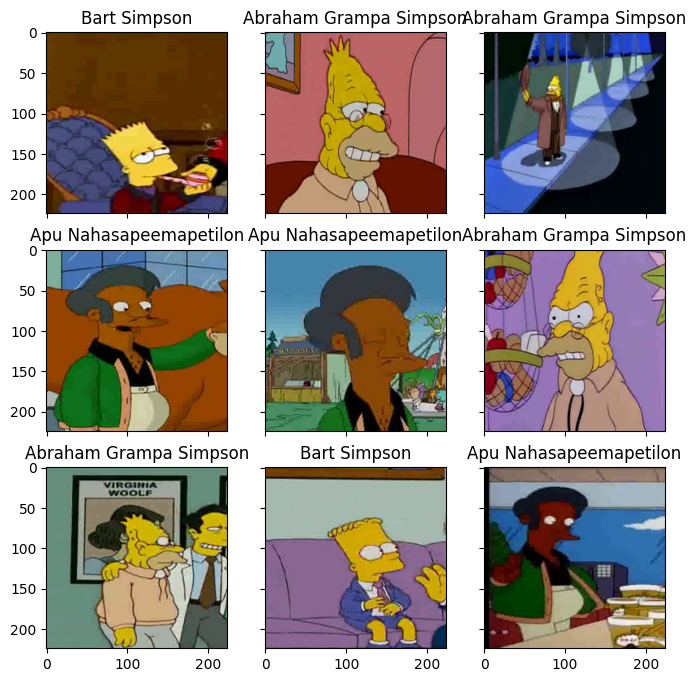

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построим нейросеть для классификации изображений

Возьмем обученную нейросеть  inception_v3, заморозим параметры и заменим классификаторы.

In [49]:
# Копируем модель

model_inception = models.inception_v3(pretrained=True)

# замораживаем параметры (веса)
# for param in model_inception.parameters():
#    param.requires_grad = False

# Изменяем классификатор
model_inception.fc = nn.Linear(2048, len(np.unique(train_val_labels)))

# Убираем дополнительный классификатор
model_inception.aux_logits = False
model_inception.AuxLogits = None

model_inception.to(DEVICE)

summary(model_inception, (4,299,299))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

Напишем функции для обучения нейросети:

In [48]:
# Часть функции для обучения
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    scheduler.step()

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)


    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

# # Часть функции для валидации
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc


# Обучение
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=1e-4)
        scheduler = lr_scheduler.StepLR(opt, step_size=8, gamma=0.1)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, scheduler)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

Обучим модель:

In [51]:
history = train(train_dataset, val_dataset, model=model_inception, epochs=30, batch_size=64)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


loss 1.7820971080911974


epoch:   3%|▎         | 1/30 [04:57<2:23:54, 297.73s/it]


Epoch 001 train_loss: 1.7821     val_loss 0.5474 train_acc 0.5569 val_acc 0.8737
loss 1.0028377707820537


epoch:   7%|▋         | 2/30 [09:49<2:17:15, 294.12s/it]


Epoch 002 train_loss: 1.0028     val_loss 0.3178 train_acc 0.7415 val_acc 0.9169
loss 0.7347168434812078


epoch:  10%|█         | 3/30 [14:34<2:10:27, 289.91s/it]


Epoch 003 train_loss: 0.7347     val_loss 0.2336 train_acc 0.8045 val_acc 0.9383
loss 0.6572237990108886


epoch:  13%|█▎        | 4/30 [19:20<2:04:58, 288.42s/it]


Epoch 004 train_loss: 0.6572     val_loss 0.2155 train_acc 0.8268 val_acc 0.9450
loss 0.5766677216091188


epoch:  17%|█▋        | 5/30 [24:11<2:00:33, 289.35s/it]


Epoch 005 train_loss: 0.5767     val_loss 0.1487 train_acc 0.8450 val_acc 0.9647
loss 0.5426595304010629


epoch:  20%|██        | 6/30 [29:17<1:57:58, 294.94s/it]


Epoch 006 train_loss: 0.5427     val_loss 0.1540 train_acc 0.8552 val_acc 0.9618
loss 0.5091349056962418


epoch:  23%|██▎       | 7/30 [34:15<1:53:32, 296.18s/it]


Epoch 007 train_loss: 0.5091     val_loss 0.1749 train_acc 0.8646 val_acc 0.9591
loss 0.42029381662662246


epoch:  27%|██▋       | 8/30 [39:09<1:48:14, 295.21s/it]


Epoch 008 train_loss: 0.4203     val_loss 0.1042 train_acc 0.8889 val_acc 0.9776
loss 0.38394807134962294


epoch:  30%|███       | 9/30 [43:53<1:42:08, 291.84s/it]


Epoch 009 train_loss: 0.3839     val_loss 0.0951 train_acc 0.8969 val_acc 0.9801
loss 0.3771897715701063


epoch:  33%|███▎      | 10/30 [48:35<1:36:15, 288.80s/it]


Epoch 010 train_loss: 0.3772     val_loss 0.0949 train_acc 0.8983 val_acc 0.9792
loss 0.3606293141961485


epoch:  37%|███▋      | 11/30 [53:17<1:30:50, 286.87s/it]


Epoch 011 train_loss: 0.3606     val_loss 0.0942 train_acc 0.9052 val_acc 0.9797
loss 0.34435122541139307


epoch:  40%|████      | 12/30 [58:02<1:25:52, 286.24s/it]


Epoch 012 train_loss: 0.3444     val_loss 0.0868 train_acc 0.9071 val_acc 0.9811
loss 0.34913960046825593


epoch:  43%|████▎     | 13/30 [1:02:43<1:20:40, 284.73s/it]


Epoch 013 train_loss: 0.3491     val_loss 0.0840 train_acc 0.9076 val_acc 0.9820
loss 0.3395922878723067


epoch:  47%|████▋     | 14/30 [1:07:30<1:16:04, 285.28s/it]


Epoch 014 train_loss: 0.3396     val_loss 0.0868 train_acc 0.9080 val_acc 0.9815
loss 0.3286799335830553


epoch:  50%|█████     | 15/30 [1:12:15<1:11:16, 285.13s/it]


Epoch 015 train_loss: 0.3287     val_loss 0.0861 train_acc 0.9115 val_acc 0.9815
loss 0.32625771616361604


epoch:  53%|█████▎    | 16/30 [1:16:59<1:06:29, 284.98s/it]


Epoch 016 train_loss: 0.3263     val_loss 0.0848 train_acc 0.9127 val_acc 0.9818
loss 0.33230012687340427


epoch:  57%|█████▋    | 17/30 [1:22:00<1:02:46, 289.73s/it]


Epoch 017 train_loss: 0.3323     val_loss 0.0841 train_acc 0.9087 val_acc 0.9817
loss 0.3254491326417716


epoch:  60%|██████    | 18/30 [1:27:10<59:08, 295.75s/it]


Epoch 018 train_loss: 0.3254     val_loss 0.0841 train_acc 0.9127 val_acc 0.9820
loss 0.3225810312318896


epoch:  63%|██████▎   | 19/30 [1:32:16<54:47, 298.88s/it]


Epoch 019 train_loss: 0.3226     val_loss 0.0833 train_acc 0.9136 val_acc 0.9820
loss 0.3254903849218824


epoch:  67%|██████▋   | 20/30 [1:37:19<50:01, 300.14s/it]


Epoch 020 train_loss: 0.3255     val_loss 0.0831 train_acc 0.9116 val_acc 0.9828
loss 0.3146622786742729


epoch:  70%|███████   | 21/30 [1:42:09<44:33, 297.04s/it]


Epoch 021 train_loss: 0.3147     val_loss 0.0837 train_acc 0.9155 val_acc 0.9818
loss 0.3207288181711909


epoch:  73%|███████▎  | 22/30 [1:46:56<39:12, 294.11s/it]


Epoch 022 train_loss: 0.3207     val_loss 0.0846 train_acc 0.9127 val_acc 0.9815
loss 0.32106429997754937


epoch:  77%|███████▋  | 23/30 [1:51:43<34:03, 291.96s/it]


Epoch 023 train_loss: 0.3211     val_loss 0.0844 train_acc 0.9124 val_acc 0.9818
loss 0.3246972670398842


epoch:  80%|████████  | 24/30 [1:56:29<29:00, 290.14s/it]


Epoch 024 train_loss: 0.3247     val_loss 0.0844 train_acc 0.9140 val_acc 0.9818
loss 0.3148563438583327


epoch:  83%|████████▎ | 25/30 [2:01:18<24:08, 289.60s/it]


Epoch 025 train_loss: 0.3149     val_loss 0.0842 train_acc 0.9159 val_acc 0.9818
loss 0.32473501647169467


epoch:  87%|████████▋ | 26/30 [2:06:07<19:17, 289.49s/it]


Epoch 026 train_loss: 0.3247     val_loss 0.0840 train_acc 0.9120 val_acc 0.9818
loss 0.3102101892967559


epoch:  90%|█████████ | 27/30 [2:11:28<14:57, 299.13s/it]


Epoch 027 train_loss: 0.3102     val_loss 0.0840 train_acc 0.9176 val_acc 0.9818
loss 0.32545048886100547


epoch:  93%|█████████▎| 28/30 [2:17:17<10:28, 314.05s/it]


Epoch 028 train_loss: 0.3255     val_loss 0.0839 train_acc 0.9122 val_acc 0.9818
loss 0.32604860144364955


epoch:  97%|█████████▋| 29/30 [2:23:07<05:24, 324.90s/it]


Epoch 029 train_loss: 0.3260     val_loss 0.0839 train_acc 0.9121 val_acc 0.9818
loss 0.31442454411817344


epoch: 100%|██████████| 30/30 [2:28:15<00:00, 296.51s/it]


Epoch 030 train_loss: 0.3144     val_loss 0.0839 train_acc 0.9164 val_acc 0.9817


In [52]:
loss, acc, val_loss, val_acc= zip(*history)

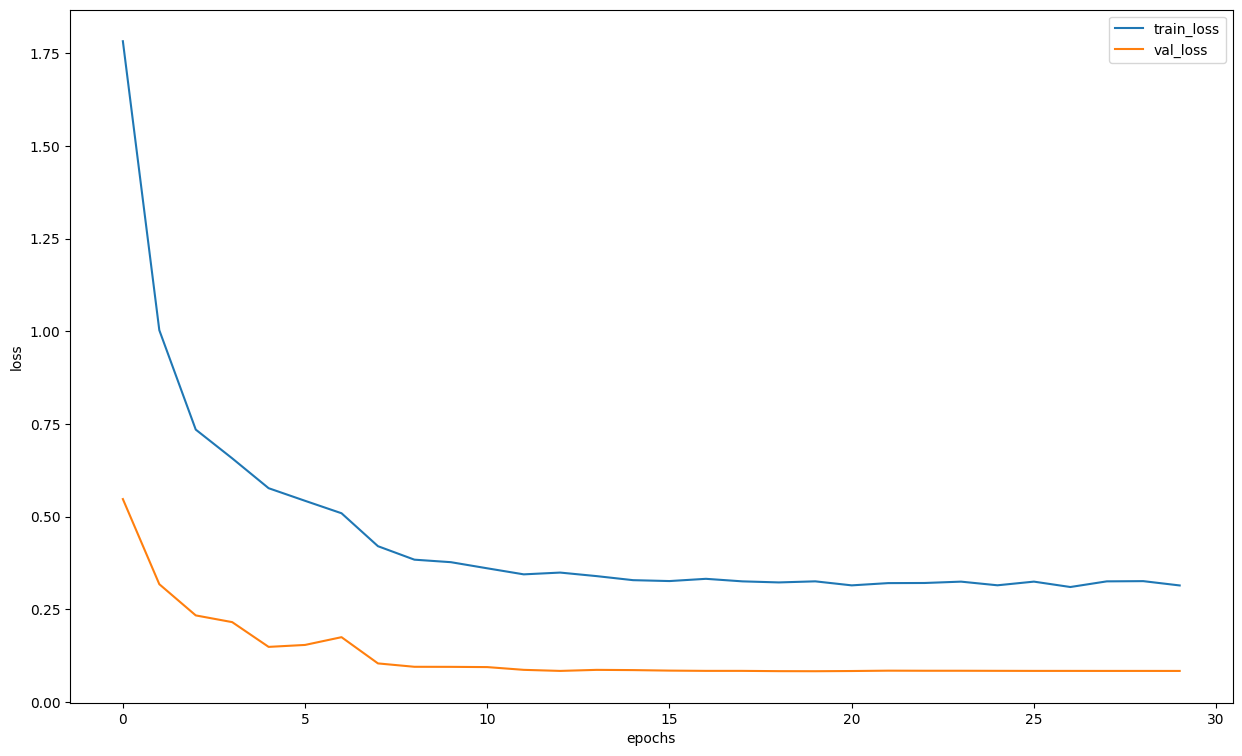

In [53]:
# Построим кривые обучения
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

**Вывод:** Использование предобученной модели inception_v3, аугементация подаваемых на модель изображений, использование scheduler позволило добиться Accuracy на валидационной выборке в 0.9818, при чем минумум loss удалось достичь уже на 18 эпохе.

Напишем функцию для предсказания для одной картинки:

In [28]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

Проверим метрику F1 на валидационной выборке

In [54]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_inception, ex_img.unsqueeze(0))

idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_inception, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

F1-оценка: 1.0


**Вывод:** Использование предобученной модели inception_v3 позволило добиться  F1 score на валидационной выборке в 1.0, что является отличным результатом.

Визуализируем полученную классификацию:

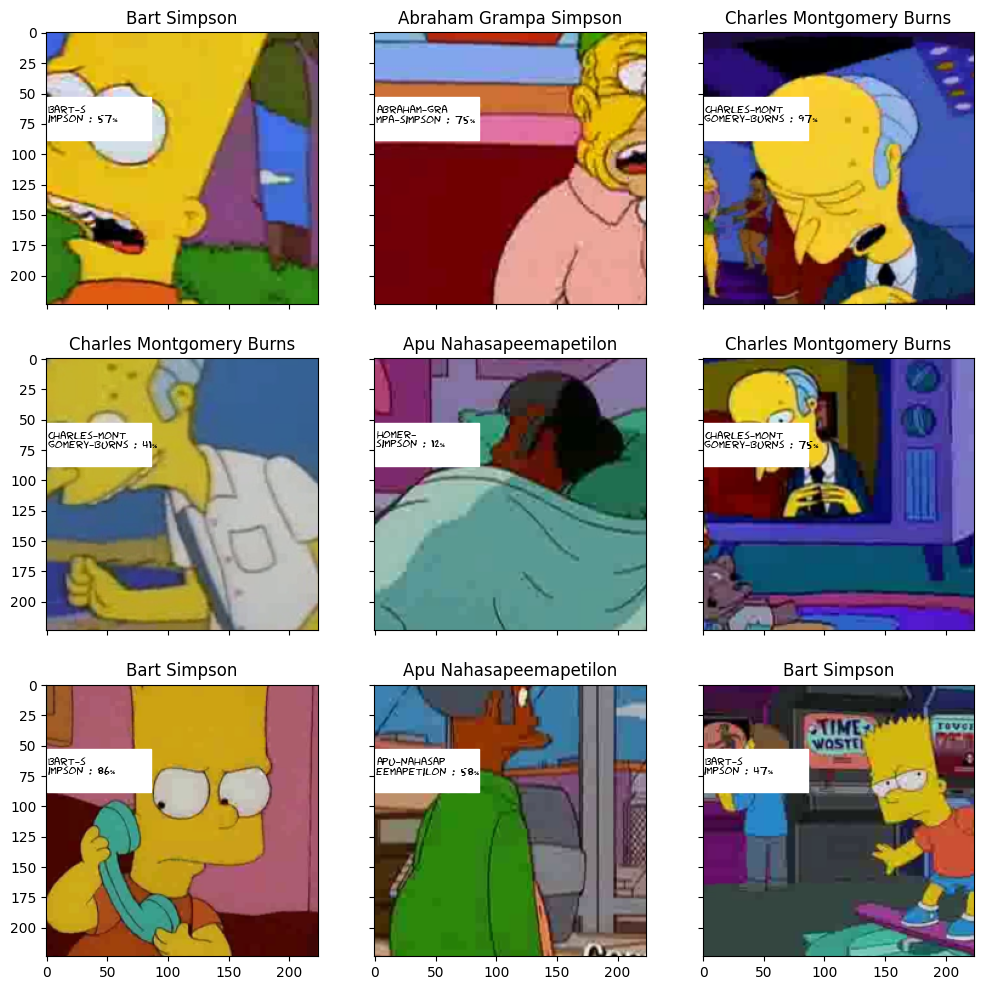

In [55]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Классифицируем тестовую выборку, создадим csv-файл с предсказаниями. Полученный файл отправим на Kaggle соревнование.

In [56]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_inception, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

! ls

my_submit = pd.read_csv("/content/gdrive/MyDrive/DataSets/Simpsons/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

my_submit.to_csv('cnn_model_inception.csv', index=False)

characters_illustration.png  label_encoder.pkl	      simple_cnn_model_inception.csv
journey-springfield.zip      sample_submission.csv    testset
kaggle.json		     simple_cnn_baseline.csv  train


**Вывод:**

**Итоговый Score на Kaggle составил 0.98831**, что является отличным показателем качества обученной модели. 
Мой номер команды для проверки Leaderboard: Vadim_Bolshev_650024495

Использование предобученной модели inception_v3 с аугементацией подаваемых на модель изображений и использованием scheduler позволило достичь точной классификации жителей Спрингфилда.